# **Vehicle Detection** 
## Overview 
Develop a pipeline to identify the lane boundaries from a front-facing camera on a car. Extensive use of OpenCV, matplotlib, numpy will be used.

The goals / steps of this project are the following:
- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

## Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import cv2
import glob
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from scipy.ndimage.measurements import label
#import imageio
#imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip 

%matplotlib inline

## SDC Helper Functions

In [2]:
def get_default_params():
    """ Package up params into a a dictionary """
    params = {}
    params['color_space']       = 'YCrCb'
    params['spatial_size']      = ( 32, 32 ) 
    params['hist_bins']         = 32 
    params['bins_range']        = ( 0, 1 ) 
    params['orient']            = 11 
    params['pix_per_cell']      = 8 
    params['cell_per_block']    = 2 
    params['hog_channel']       = 'ALL' 
    params['spatial_feat']      = True 
    params['hist_feat']         = False 
    params['hog_feat']          = True 
    params['y_start_stop']      = [ 400, 600 ] 
    params['x_start_stop']      = [ 0, 1280 ] 
    params['xy_overlap']        = ( 0.6, 0.6 )
    params['heatmap_threshold'] = 1 
    params['perspective_windows'] = [80, 96, 112, 128, 160]
    return params

def get_hog_features( img, orient, pix_per_cell, cell_per_block, vis = False, feature_vec = True ):
    hog_descriptor = { }
    entry = ( pix_per_cell, cell_per_block, orient )
    if entry in hog_descriptor:
        hd = hog_descriptor[ entry ]
    else:
        hd = cv2.HOGDescriptor(
                    ( pix_per_cell * cell_per_block, pix_per_cell * cell_per_block ),
                    ( pix_per_cell * cell_per_block, pix_per_cell * cell_per_block ),
                    ( pix_per_cell, pix_per_cell ),
                    ( pix_per_cell, pix_per_cell ),
                    orient )
        hog_descriptor[ entry ] = hd
        
    img4cv2 = ( img * 255 ).astype( 'uint8' )
    f = hd.compute( img4cv2 )
    g = f.reshape( f.shape[0] )
    return g

def bin_spatial( img, size = ( 32, 32 ) ):
    """Create the feature vector"""
    features = cv2.resize( img, size ).ravel()
    return features

def color_hist( img, nbins=32, bins_range = ( 0, 256 ) ):
    """ Compute the histogram of the color channels separately """
    channel1_hist = np.histogram( img[:,:,0], bins = nbins, range = bins_range )
    channel2_hist = np.histogram( img[:,:,1], bins = nbins, range = bins_range )
    channel3_hist = np.histogram( img[:,:,2], bins = nbins, range = bins_range )
    hist_features = np.concatenate( ( channel1_hist[0], channel2_hist[0], channel3_hist[0] ) )
    return hist_features

def single_img_features( img, params ):

    color_space     = params['color_space']
    spatial_size    = params['spatial_size']
    hist_bins       = params['hist_bins']
    bins_range      = params['bins_range'] 
    orient          = params['orient'] 
    pix_per_cell    = params['pix_per_cell']
    cell_per_block  = params['cell_per_block']
    hog_channel     = params['hog_channel']
    spatial_feat    = params['spatial_feat']
    hist_feat       = params['hist_feat']
    hog_feat        = params['hog_feat']

    img_features = []
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor( img, cv2.COLOR_RGB2HSV )
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor( img, cv2.COLOR_RGB2LUV )
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor( img, cv2.COLOR_RGB2HLS )
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor( img, cv2.COLOR_RGB2YUV )
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor( img, cv2.COLOR_RGB2YCrCb )
    else:
        feature_image = np.copy( img )
        
    if spatial_feat == True:
        spatial_features = bin_spatial( feature_image, size = spatial_size ) 
        img_features.append( spatial_features )

    if hist_feat == True:
        hist_features = color_hist( feature_image, nbins = hist_bins )
        img_features.append( hist_features )
        
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range( feature_image.shape[2] ):
                hog_features.extend( get_hog_features(feature_image[:,:,channel],
                                                      orient,
                                                      pix_per_cell, 
                                                      cell_per_block,
                                                      vis = False,
                                                      feature_vec = True ) )
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                            orient,
                                            pix_per_cell,
                                            cell_per_block,
                                            vis = False,
                                            feature_vec = True )
        img_features.append( hog_features )

    return np.concatenate( img_features )

def extract_features( img_files, params ):
    """ Extract features from all images """
    features = []
    for path in ( img_files ):
        img = mpimg.imread( path )
        #img = img.astype(np.float32)/255
        img_features = single_img_features( img, params )
        features.append( img_features )
    return features

## Get the Training data

Number of car images = 8792
Number of non-car images = 8968


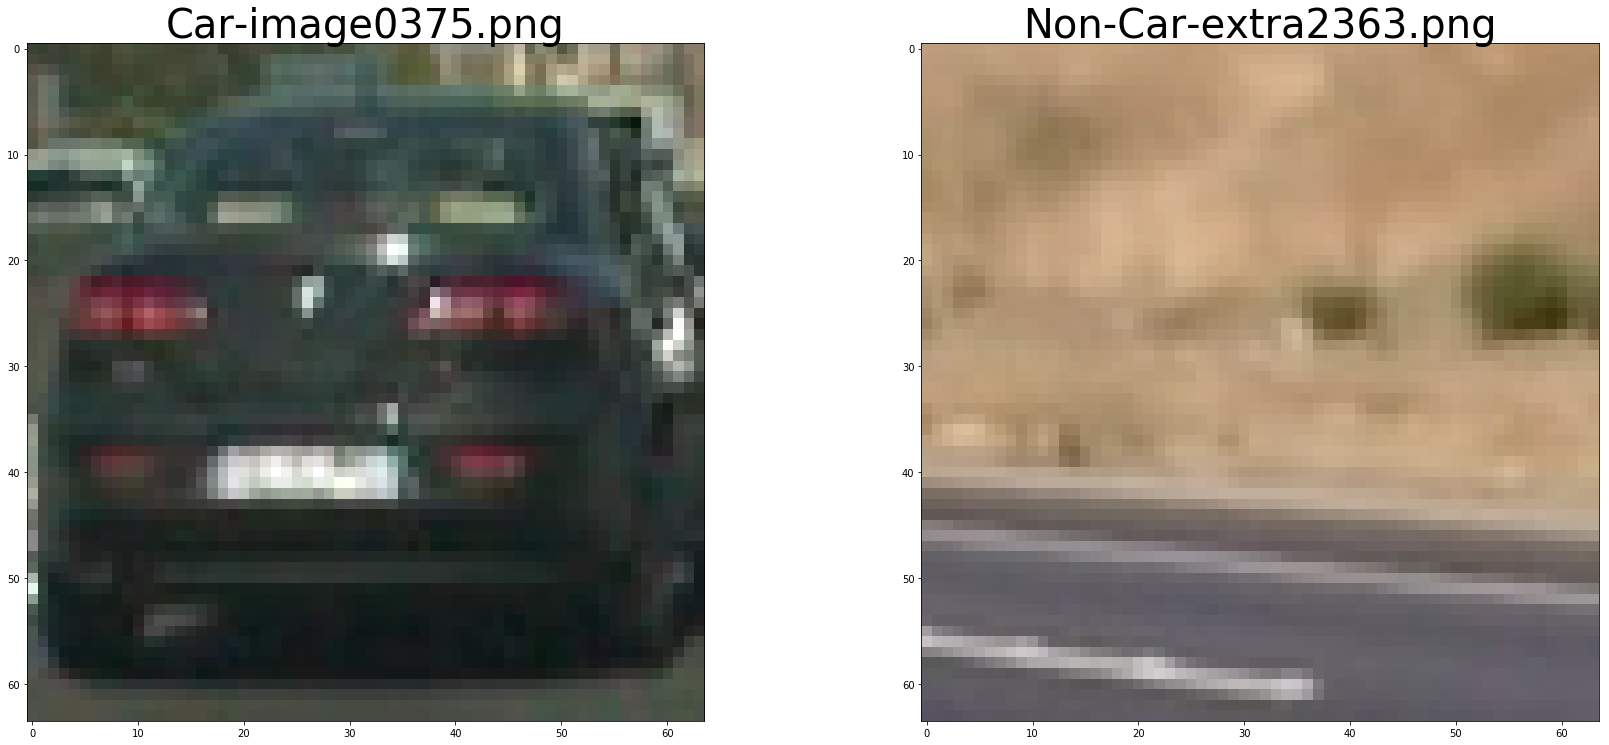

In [3]:
# Get all car images
car_images = glob.glob('vehicles/*/*.png')
print( "Number of car images = {}".format( len( car_images ) ) )

# Get all non-car images
non_car_images = glob.glob('non-vehicles/*/*.png')
print( "Number of non-car images = {}".format( len( non_car_images ) ) )

# Read random car image
car_path = car_images[ np.random.randint( 0, len( car_images ) ) ]
_, car_filename = os.path.split( car_path )
car_img = mpimg.imread( car_path )

# Read random non-car image
non_car_path = non_car_images[ np.random.randint( 0, len( non_car_images ) ) ]
_, non_car_filename = os.path.split( non_car_path )
non_car_img = mpimg.imread( non_car_path )

f, (ax1, ax2) = plt.subplots( 1, 2, figsize=( 25, 10 ) )
f.subplots_adjust( hspace = .2, wspace=.05 )
f.tight_layout()
ax1.imshow( car_img )
ax1.set_title( 'Car-' + car_filename, fontsize=40 )
ax2.imshow( non_car_img )
ax2.set_title( 'Non-Car-' + non_car_filename, fontsize=40 );       

## Get the Test Data

Number of test images = 6


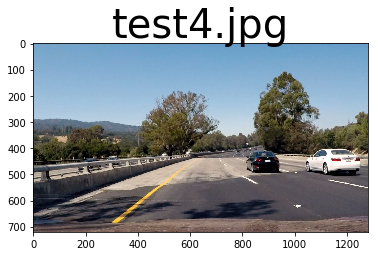

In [4]:
# Get all car images
test_images = glob.glob( 'test_images/test*.jpg' )

print( "Number of test images = {}".format( len( test_images ) ) )

# Read a random test image
path = test_images[ np.random.randint( 0, len( test_images ) ) ]
_, filename = os.path.split( path )
img = mpimg.imread( path )

plt.imshow( img )
plt.title( filename, fontsize=40 );


## Extract all Features from both Data Sets

In [5]:
params = get_default_params()

car_features = extract_features( car_images, params )

non_car_features = extract_features( non_car_images, params )

print( 'Number of car_features = {}'.format( len( car_features[0] ) ) )

print( 'Number of non_car_features = {}'.format( len( non_car_features[0] ) ) )

Number of car_features = 9540
Number of non_car_features = 9540


## Normalize the data sets

In [6]:
X = np.vstack( ( car_features, non_car_features ) ).astype( np.float64 )
X_scaler = StandardScaler().fit( X )
scaled_X = X_scaler.transform( X )
y = np.hstack( ( np.ones( len( car_features ) ), np.zeros( len( non_car_features ) ) ) )

## Visualize the normalized data sets

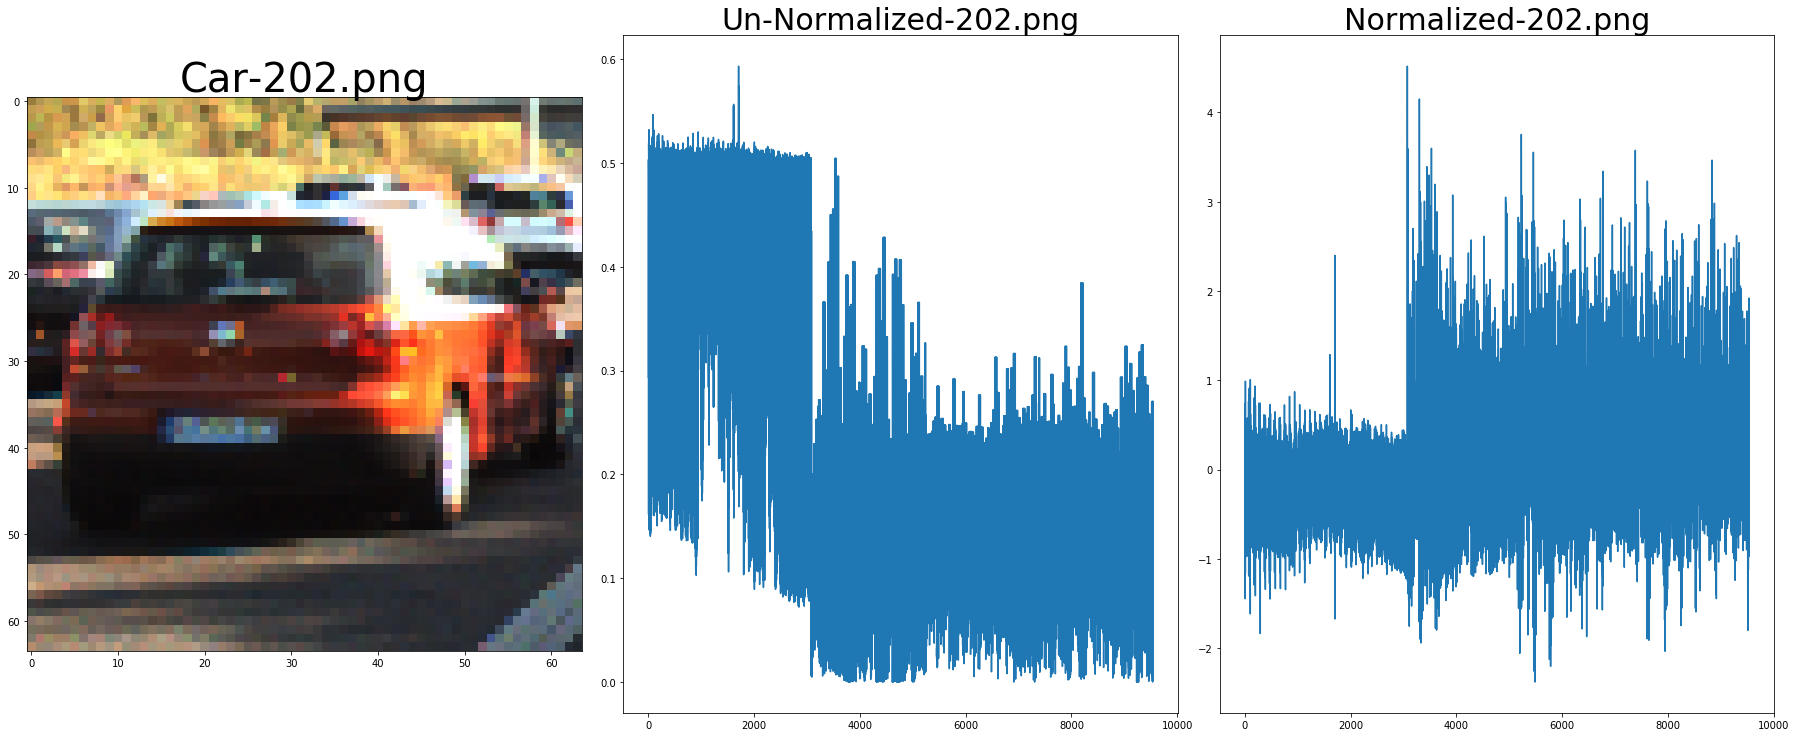

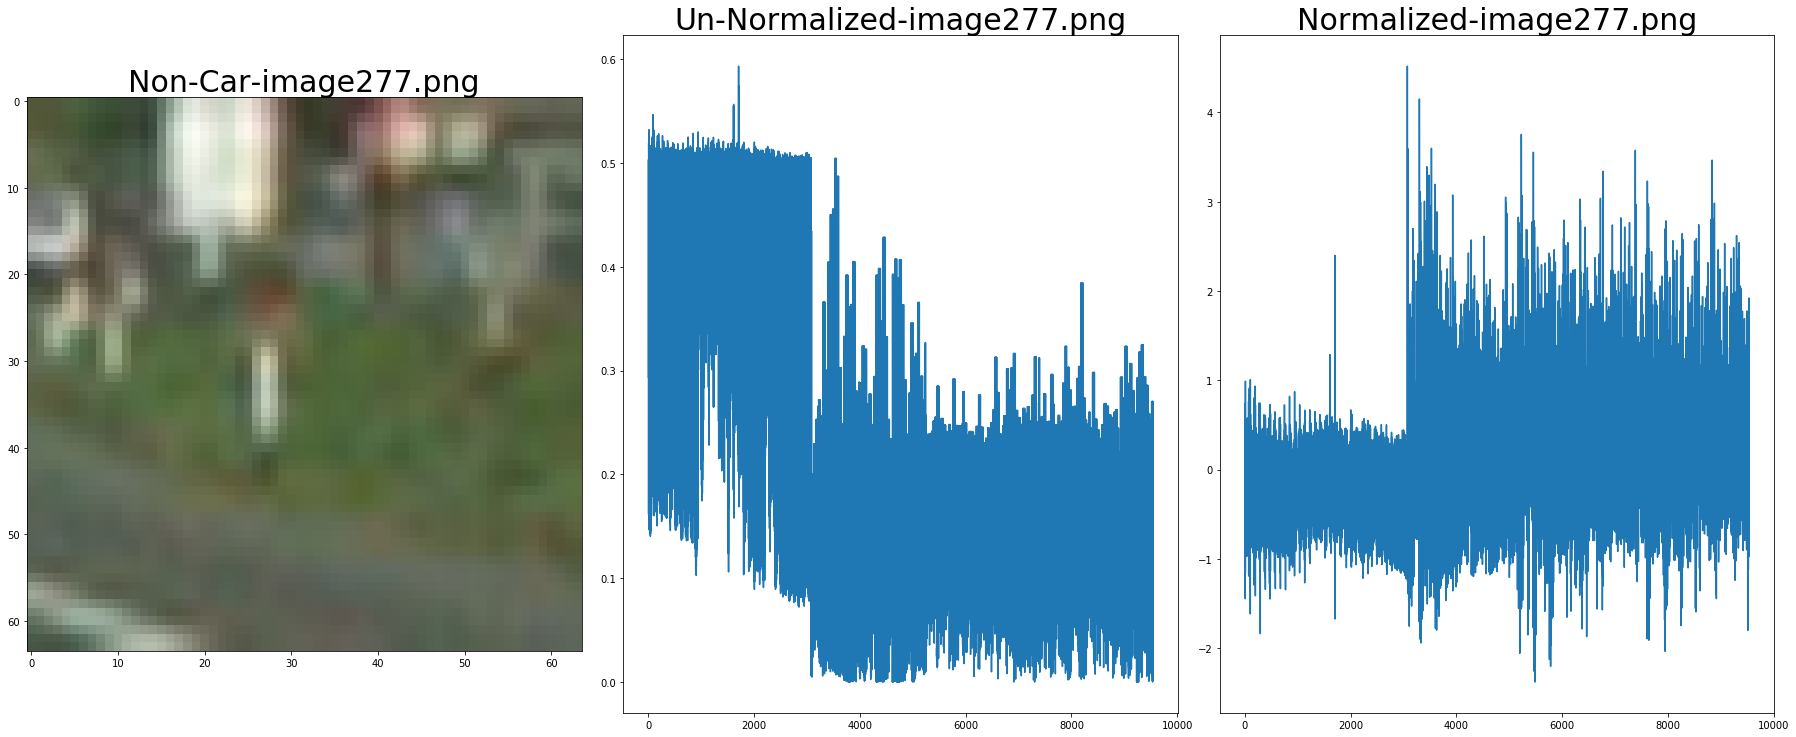

In [7]:
#
# Display a random car image along with the un-normalized, and normalized image data
#
car_path = car_images[ np.random.randint( 0, len( car_images ) ) ]
_, car_filename = os.path.split( car_path )
car_img = mpimg.imread( car_path )

f, (ax1, ax2,ax3) = plt.subplots( 1, 3, figsize=( 25, 10 ) )
f.subplots_adjust( hspace = .2, wspace=.05 )
f.tight_layout()
ax1.imshow( car_img )
ax1.set_title( 'Car-' + car_filename, fontsize=40 )
ax2.plot( X[ 0 ])
ax2.set_title('Un-Normalized-' + car_filename, fontsize=30 )
ax3.plot( scaled_X[0] )
ax3.set_title( 'Normalized-' + car_filename, fontsize=30 );    

#
# Display a random non_car image along with the un-normalized, and normalized image data
#
non_car_path = non_car_images[ np.random.randint( 0, len( non_car_images ) ) ]
_, non_car_filename = os.path.split( non_car_path )
non_car_img = mpimg.imread( non_car_path )

f, (ax1, ax2,ax3) = plt.subplots( 1, 3, figsize=( 25, 10 ) )
f.subplots_adjust( hspace = .2, wspace=.05 )
f.tight_layout()
ax1.imshow( non_car_img )
ax1.set_title( 'Non-Car-' + non_car_filename, fontsize=30 )
ax2.plot( X[ 0 ])
ax2.set_title('Un-Normalized-' + non_car_filename, fontsize=30 )
ax3.plot( scaled_X[0] )
ax3.set_title( 'Normalized-' + non_car_filename, fontsize=30 );    

## Split up the data sets into training and test sets

In [8]:
# split into 80% for training 20% for test
random_state = np.random.randint( 0, len( car_features ) )
X_train, X_test, y_train, y_test = train_test_split( scaled_X, y, test_size = 0.2, random_state=random_state )

## Train the model

In [9]:
svc = LinearSVC()

In [10]:
svc.fit( X_train, y_train )
print( 'LinearSVC Test Accuracy = {:.2%}'.format( svc.score( X_test, y_test ) ) )

LinearSVC Test Accuracy = 99.32%


## Save and Reload the model

In [11]:
# save the mode
joblib.dump( ( svc, X_scaler ), 'model.p')

# reload
svc, X_scaler = joblib.load('model.p')

## Visualize bounding boxes on the Test Data

filename =  test1.jpg
filename =  test2.jpg
filename =  test3.jpg
filename =  test4.jpg
filename =  test5.jpg
filename =  test6.jpg


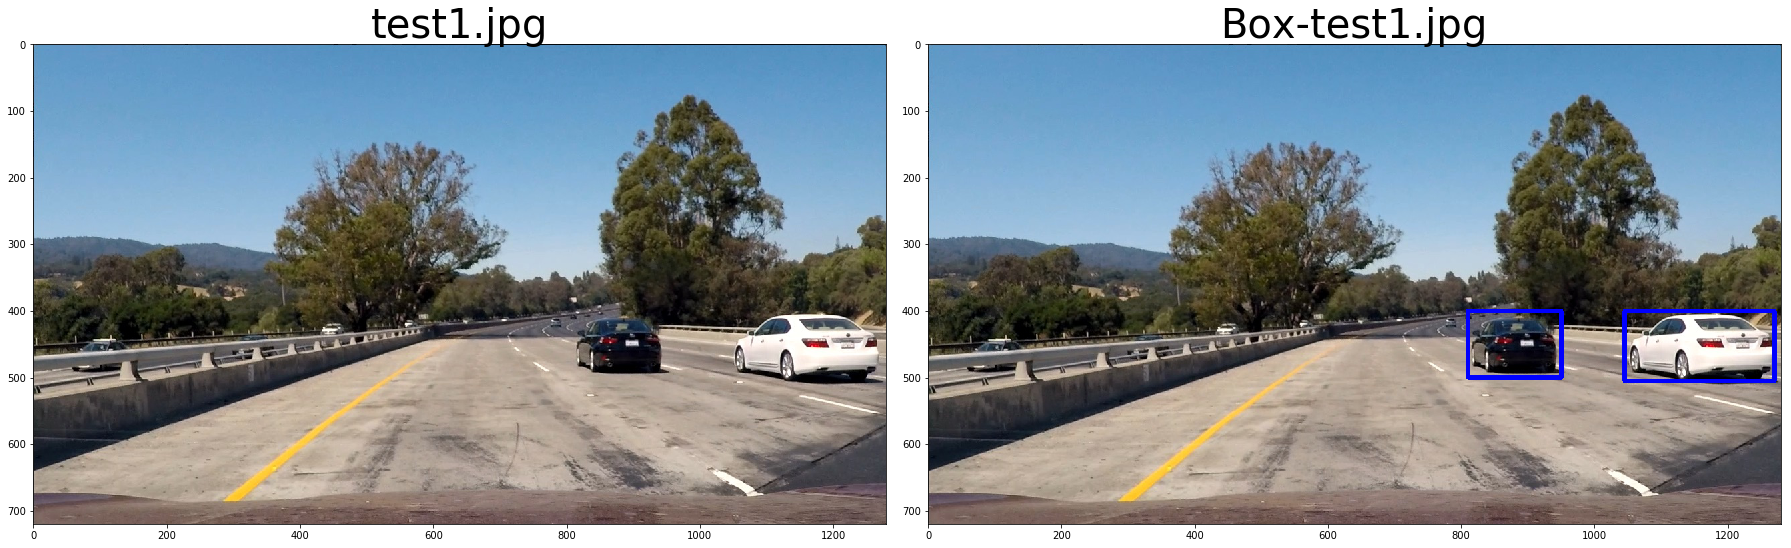

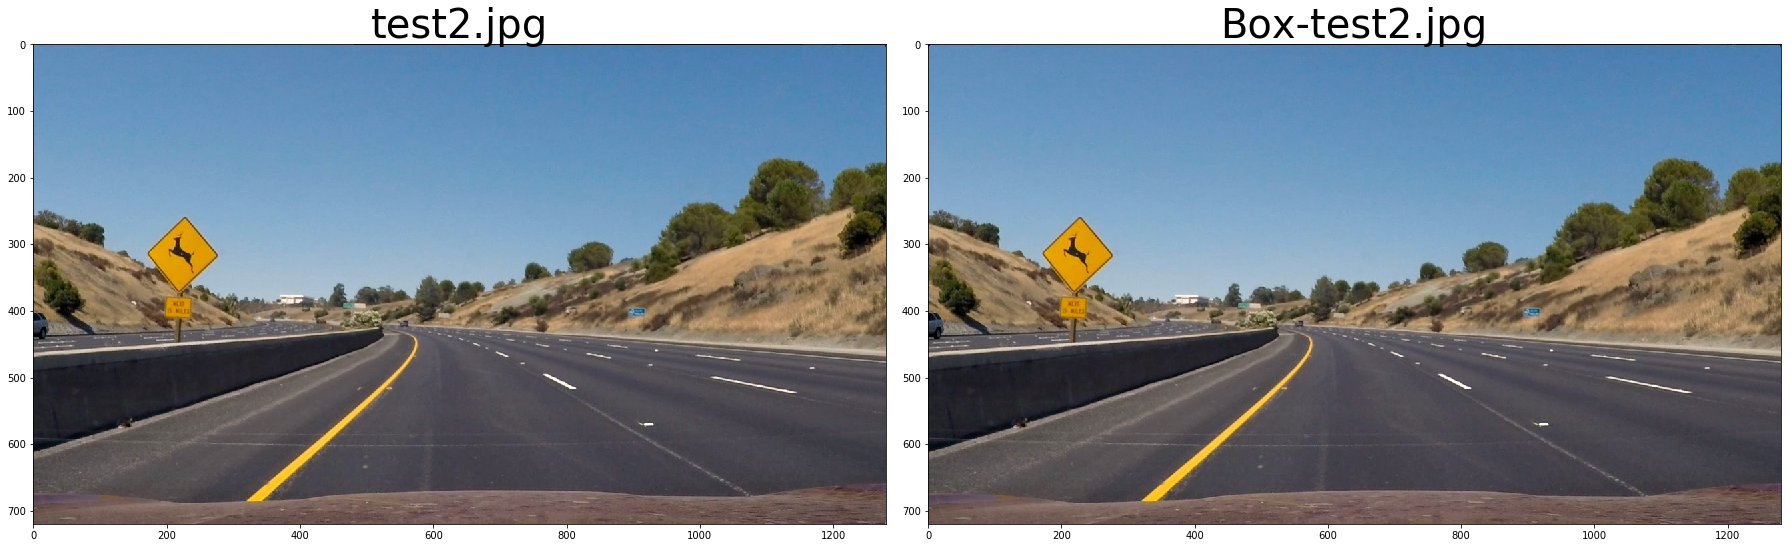

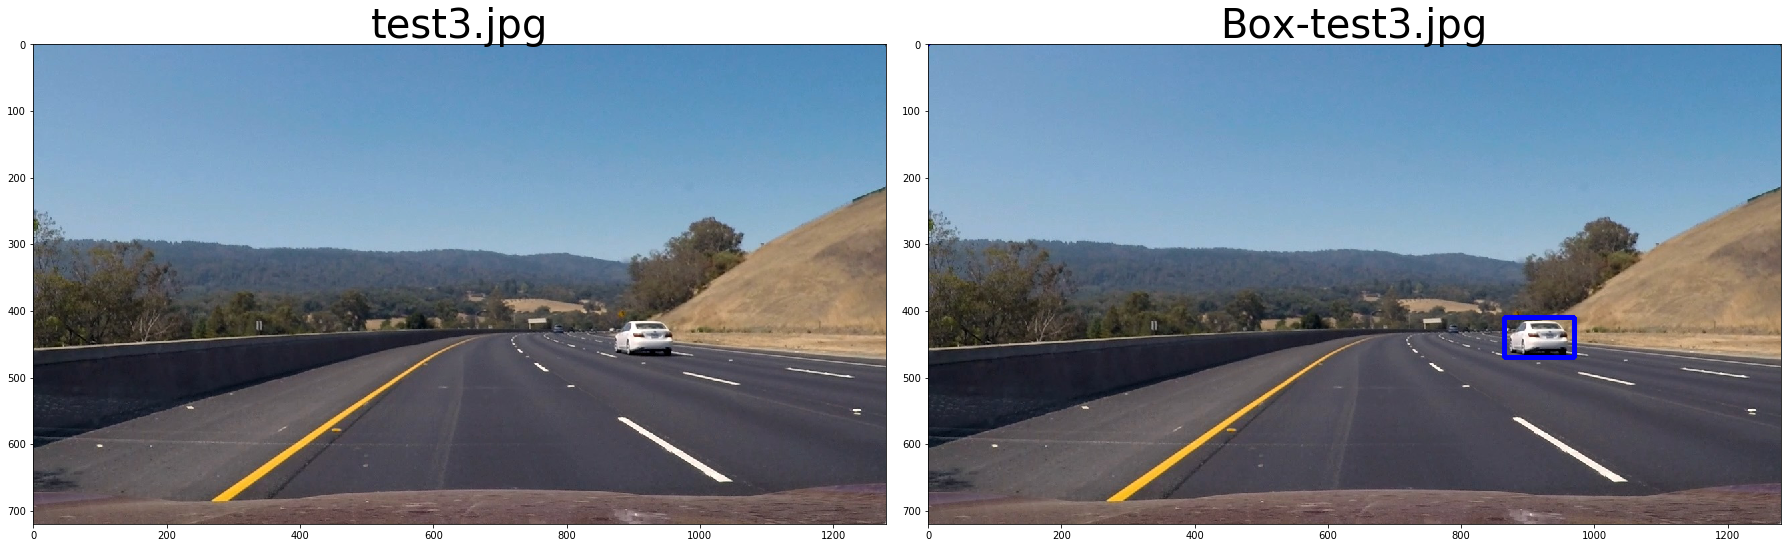

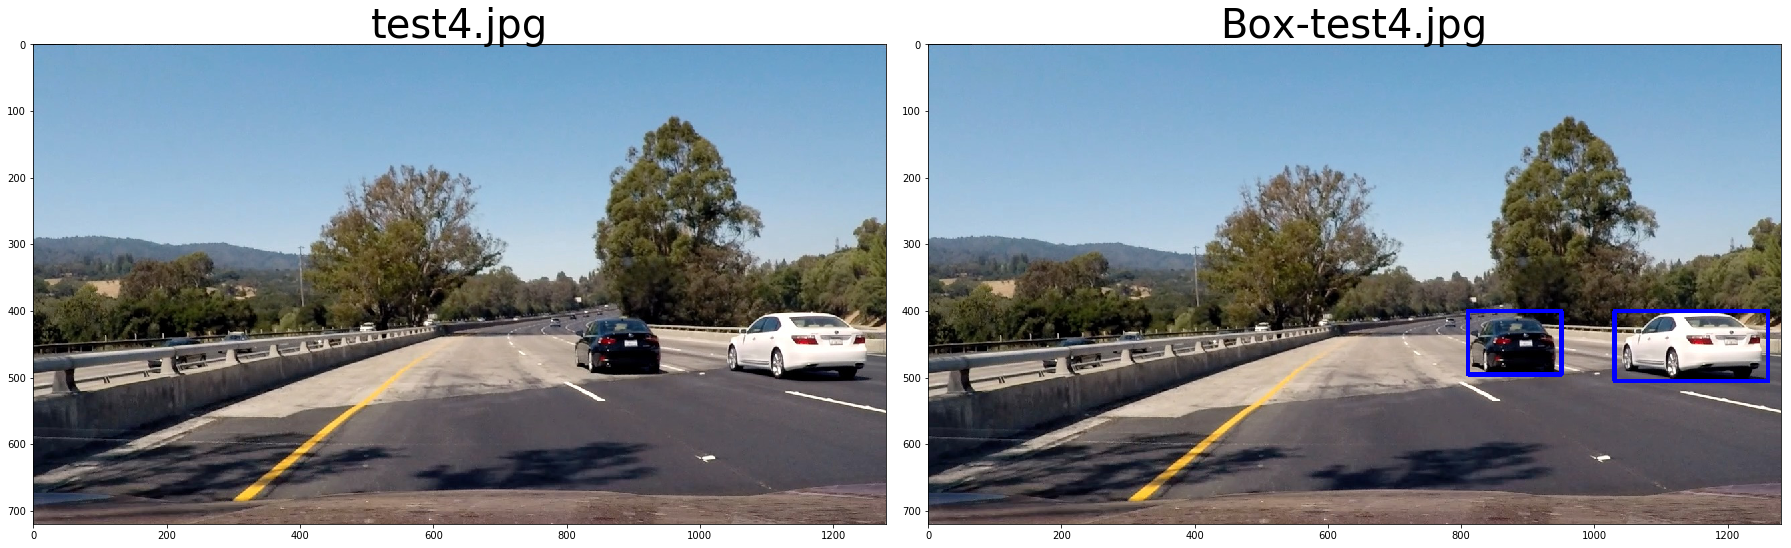

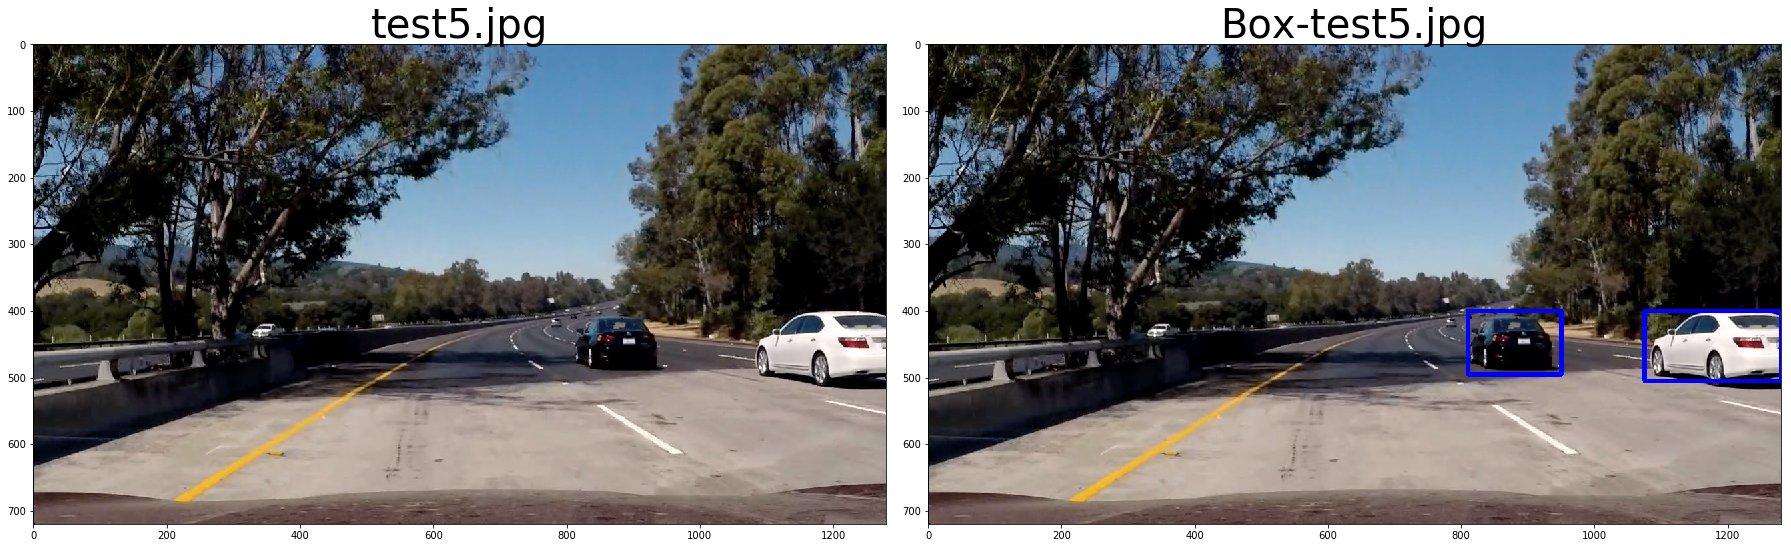

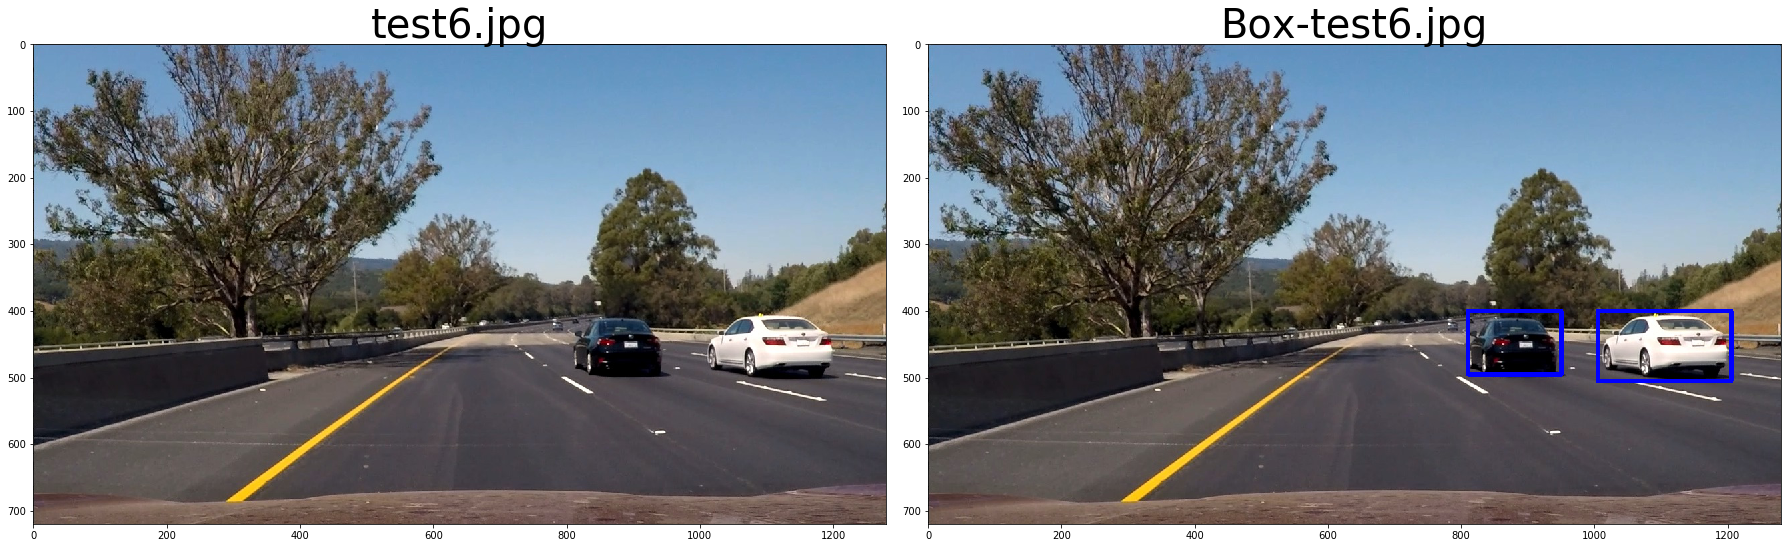

In [12]:
def draw_boxes( img, bboxes, color = ( 0, 0, 255 ), thick=6 ):
    img_copy = np.copy( img )
    for bbox in bboxes:
        cv2.rectangle( img_copy, bbox[0], bbox[1], color, thick )
    return img_copy

for path in sorted( test_images ):
    _, filename = os.path.split( path )
    print( "filename = ",filename )
    
    if filename == 'test1.jpg':
        bboxes = [ ( ( 810,400 ),( 950,500 ) ), ( ( 1045,400 ), ( 1270,505 ) ) ]
    elif filename == 'test2.jpg':
        bboxes = [ ( ( 0,0 ),( 0,0 ) ), ( ( 0,0 ), ( 0,0 ) ) ]
    elif filename == 'test3.jpg':
        bboxes = [ ( ( 865,410 ),( 970,470 ) ), ( ( 0,0 ), ( 0,0 ) ) ]
    elif filename == 'test4.jpg':
        bboxes = [ ( ( 810,400 ),( 950,495 ) ), ( ( 1030,400 ), ( 1260,505 ) ) ]
    elif filename == 'test5.jpg':
        bboxes = [ ( ( 810,400 ),( 950,495 ) ), ( ( 1075,400 ), ( 1280,505 ) ) ]
    elif filename == 'test6.jpg':
        bboxes = [ ( ( 810,400 ),( 950,495 ) ), ( ( 1005,400 ), ( 1205,505 ) ) ]
    else:
        print( "unknown filename" )
    img = mpimg.imread( path ) 
    _, filename = os.path.split( path )        
    box_img = draw_boxes( img, bboxes = bboxes )
    f, (ax1, ax2) = plt.subplots( 1, 2, figsize=( 25, 10 ) )
    f.subplots_adjust( hspace = .2, wspace=.05 )
    f.tight_layout()
    ax1.imshow( img )
    ax1.set_title( filename, fontsize=40 )
    ax2.imshow( box_img )
    ax2.set_title( 'Box-'+filename, fontsize=40 );


# Sliding Window Search

In [13]:
def slide_window( img, xy_window, params ):

    x_start_stop    = params['x_start_stop'] 
    y_start_stop    = params['y_start_stop'] 
    xy_overlap      = params['xy_overlap'] 

    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int( xy_window[0] * ( 1 - xy_overlap[0] ) )
    ny_pix_per_step = np.int( xy_window[1] * ( 1 - xy_overlap[1] ) )
    
    # Compute the number of windows in x/y
    nx_buffer = np.int( xy_window[0] * ( xy_overlap[0] ) )
    ny_buffer = np.int( xy_window[1] * ( xy_overlap[1] ) )
    nx_windows = np.int( ( xspan - nx_buffer ) / nx_pix_per_step )
    ny_windows = np.int( ( yspan - ny_buffer ) / ny_pix_per_step )

    window_list = []

    for ys in range( ny_windows ):
        for xs in range( nx_windows ):
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append( ( ( startx, starty ), ( endx, endy ) ) )
    return window_list

def search_windows( img, windows, svc, scaler, params ):
    on_windows = []
    for window in windows:
        test_img = cv2.resize( img[ window[0][1]:window[1][1], window[0][0]:window[1][0]], ( 64, 64 ) )
        features = single_img_features( test_img, params )
        test_features = scaler.transform( np.array( features ).reshape( 1, -1 ) )
        prediction = svc.predict( test_features )
        if prediction == 1:
            on_windows.append( window )
    return on_windows

def search_perspective_windows( img, perspective_windows, svc, X_scaler, params ):
    hot_windows = []
    for xywin in perspective_windows:
        xy_window = (xywin, xywin)
        windows = slide_window( img, xy_window, params )
        hot = search_windows( img, windows, svc, X_scaler, params )
        hot_windows.extend( hot )
    return hot_windows

def add_heat( heatmap, bbox_list ):
    for box in bbox_list:
        heatmap[ box[0][1]:box[1][1], box[0][0]:box[1][0] ] += 1
    return heatmap

def apply_threshold( heatmap, threshold ):
    heatmap[ heatmap <= threshold ] = 0
    return heatmap

def draw_labeled_bboxes( img, labels ):
    for car_number in range( 1, labels[1]+1 ):
        nonzero = ( labels[0] == car_number ).nonzero()
        nonzeroy = np.array( nonzero[0] )
        nonzerox = np.array( nonzero[1] )
        bbox = ( ( np.min( nonzerox ), np.min( nonzeroy ) ), ( np.max( nonzerox ), np.max( nonzeroy ) ) )
        cv2.rectangle( img, bbox[0], bbox[1], (0,0,255), 6 )
    return img

## Visualize Heatmap and Feature box on Test Images

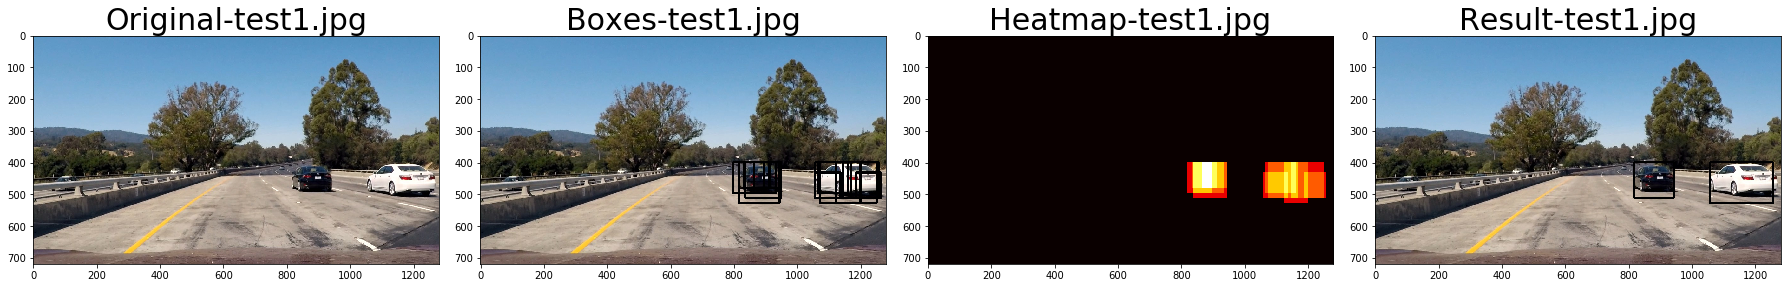

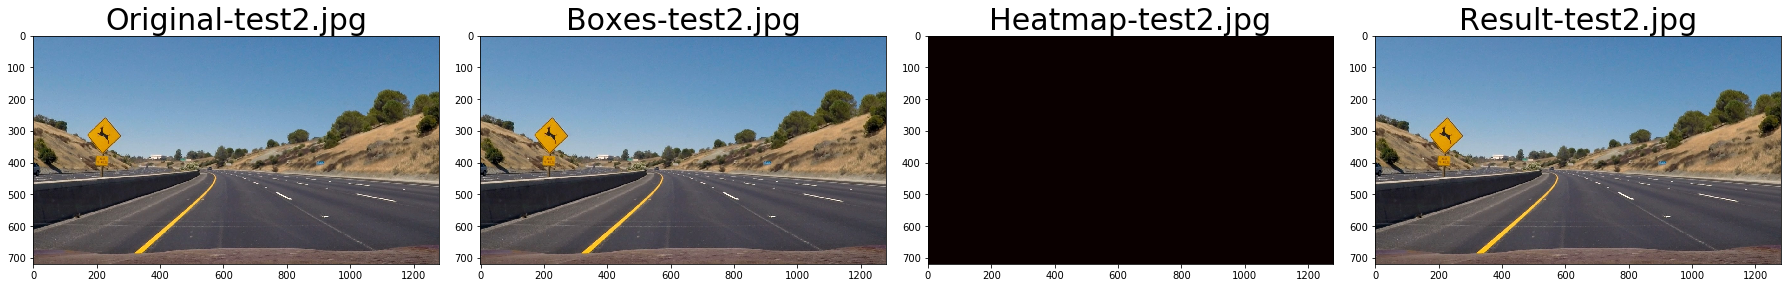

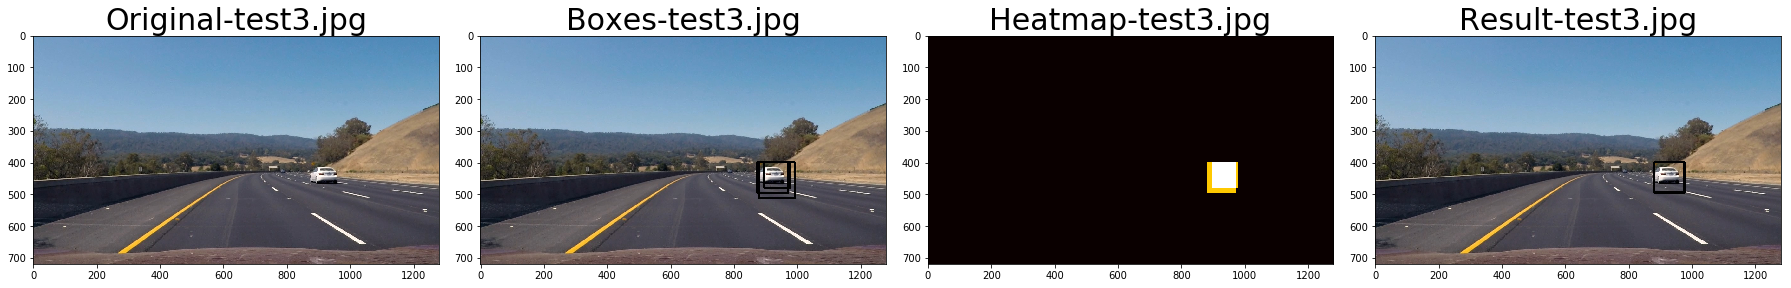

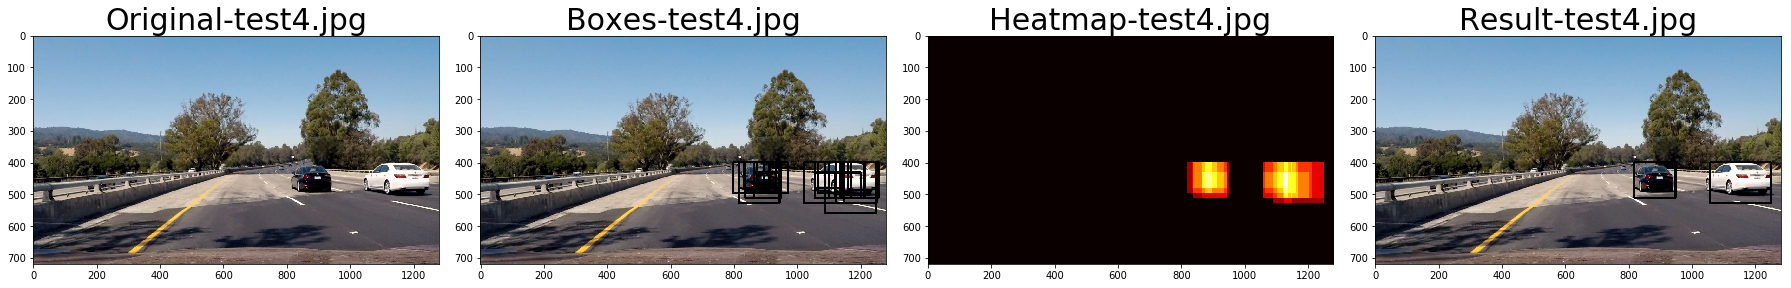

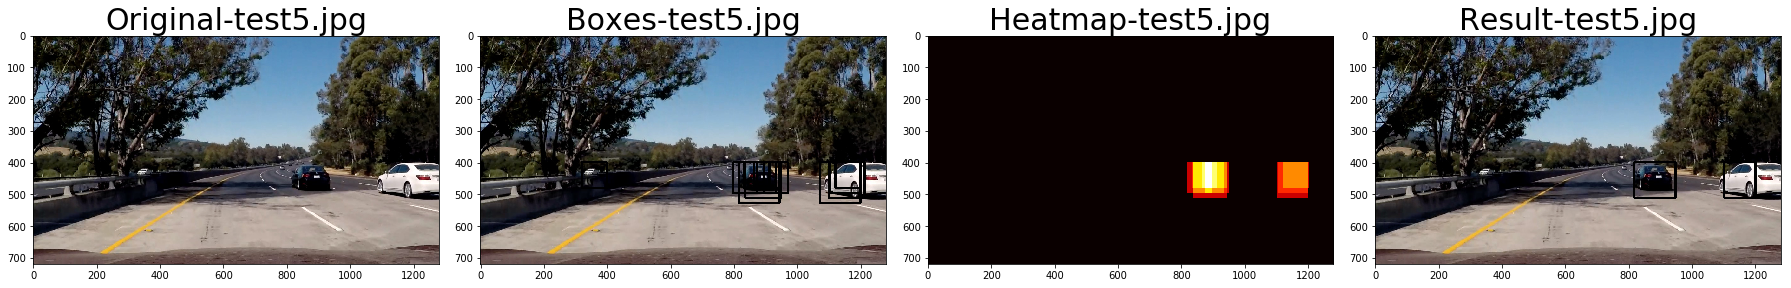

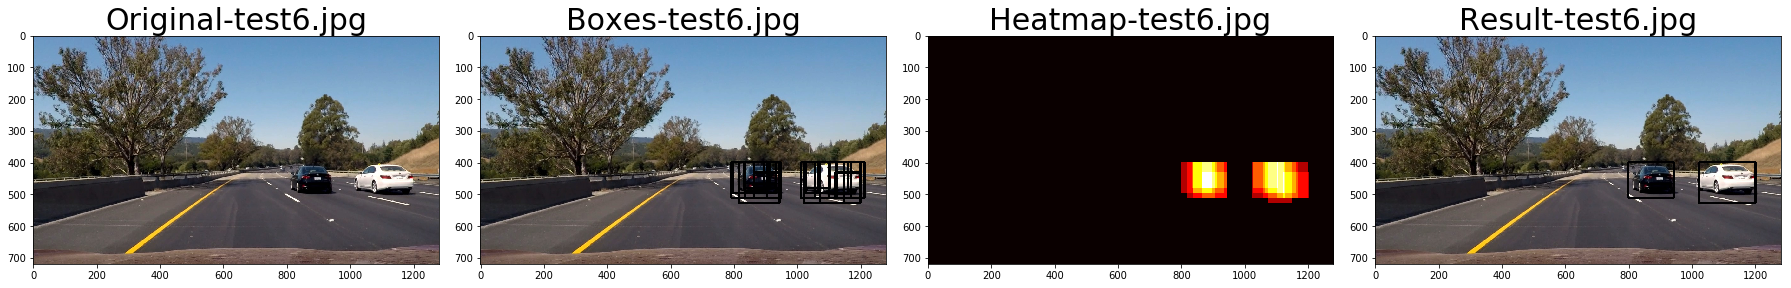

In [14]:
perspective_windows  = params['perspective_windows']
heatmap_threshold   = params['heatmap_threshold']

for path in sorted( test_images ):
    img = mpimg.imread( path )
    img = img.astype(np.float32)/255
    _,filename = os.path.split( path ) 

    # Hot windows
    hot_windows = search_perspective_windows( img, perspective_windows, svc, X_scaler, params )
    box_1_img = draw_boxes( img, hot_windows, color = (0, 0, 255), thick=6 )

    # Heatmap
    heat = np.zeros_like( img[:,:,0]).astype( np.float )
    heat = add_heat( heat, hot_windows )
    heat = apply_threshold( heat, heatmap_threshold )
    heatmap = np.clip( heat, 0, 255 )

    # Use label to find final boxes
    labels = label( heatmap )
    draw_img = draw_labeled_bboxes( np.copy( img ), labels )
   
    f, (ax1, ax2,ax3, ax4) = plt.subplots( 1, 4, figsize=( 25, 10 ) )
    f.subplots_adjust( hspace = .2, wspace=.05 )
    f.tight_layout()
    ax1.imshow( mpimg.imread( path ) )
    ax1.set_title( 'Original-' + filename, fontsize=30 )
    
    ax2.imshow( box_1_img)
    ax2.set_title('Boxes-' + filename, fontsize=30 )
    
    ax3.imshow( heatmap, cmap='hot' )
    ax3.set_title( 'Heatmap-' + filename, fontsize=30 )
    
    ax4.imshow( draw_img, cmap = None )
    ax4.set_title( 'Result-' + filename, fontsize=30 );

## Create process_image for the video pipeline

In [15]:
def process_image( img ):

    # normalize.
    img = img.astype( np.float32 )/255
    hot_windows = search_perspective_windows( img, perspective_windows, svc, X_scaler, params )

    heat = np.zeros_like( img[:,:,0]).astype( np.float )
    heat = add_heat( heat, hot_windows )
    heat = apply_threshold( heat, heatmap_threshold )
    heatmap = np.clip( heat, 0, 255 )    

    # Find final boxes from heatmap using label function
    labels = label( heatmap )
    output = draw_labeled_bboxes( np.copy( img ), labels )

    return output

## Create video

In [ ]:
output_file = 'output_test_video.mp4'
clip = VideoFileClip("test_video.mp4")
output_clip = clip.fl_image( process_image )
%time output_clip.write_videofile( output_file, audio=False )